In [3]:

from model_track.binning import (
    BinApplier,
    TreeBinner,
    QuantileBinner
)

from model_track.woe import (
    WoeCalculator,
    WoeByPeriod
)
from model_track.stats import (
    get_summary
)
from model_track.stability import (
    WoeStability, CategoryMapper
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
np.random.seed(42)

n_per_period = 50
periods = ["2024-01", "2024-02", "2024-03", "2024-04"]

rows = []

for period in periods:
    idade = np.random.normal(loc=40, scale=12, size=n_per_period).clip(18, 75)
    renda = np.random.lognormal(mean=8.2, sigma=0.5, size=n_per_period)

    # ----- introduzindo missing -----
    idade[np.random.rand(n_per_period) < 0.05] = np.nan
    renda[np.random.rand(n_per_period) < 0.05] = np.nan

    # ----- probabilidade do evento (default, fraude, etc.) -----
    prob_event = (
        0.15
        + 0.002 * (idade < 25)
        + 0.003 * (idade > 60)
        + 0.004 * (renda < 2500)
    )

    prob_event = np.clip(prob_event, 0.02, 0.7)

    vr = np.random.binomial(1, prob_event)

    rows.append(
        pd.DataFrame(
            {
                "idade": idade,
                "renda": renda,
                "vr": vr,
                "period": period,
            }
        )
    )

df = pd.concat(rows, ignore_index=True)
df["period"] = pd.to_datetime(df["period"], format="%Y-%m")
# ----- Summary inicial -----
df_summary = get_summary(df=df)
df_summary


,column_name,dtype,n_na,pct_na,top_class,top_class_pct,n_distinct,distinct_values,min,max
0,idade,float64,5,2.5,18.0,4.615385,188,...,18.0,70.880318
1,renda,float64,12,6.0,4281.428458,0.531915,189,...,982.52663,16974.040121
2,vr,int64,0,0.0,0,76.000000,2,"[0, 1]",0,1
3,period,datetime64[ns],0,0.0,2024-01-01 00:00:00,25.000000,4,"[2024-01-01 00:00:00, 2024-02-01 00:00:00, 202...",2024-01-01 00:00:00,2024-04-01 00:00:00


In [5]:
# ----- Binning supervisionado -----
features = ["renda", "idade"]
target = "vr"


binner = TreeBinner(
    max_depth=2,
    min_samples_leaf=1
)
binner.fit(df, feature='renda', target=target)
bins = binner.bins_
bins = [round(b, 2) for b in bins]
applier = BinApplier(df)
df[f"{'renda'}_cat"] = applier.apply('renda', bins)

binner = QuantileBinner(n_bins=3)
binner.fit(df, feature='idade')
bins = binner.bins_
bins = [round(b, 2) for b in bins]
applier = BinApplier(df)
df[f"{'idade'}_cat"] = applier.apply('idade', bins)

# ----- Tratamento explícito de missing pós-binning -----
for feature in features:
    df[f"{feature}_cat"] = (
        df[f"{feature}_cat"]
        .astype("object")
        .fillna("N/A")
    )

# ----- Summary após binning -----
get_summary(df=df)


,column_name,dtype,n_na,pct_na,top_class,top_class_pct,n_distinct,distinct_values,min,max
0,idade,float64,5,2.5,18.0,4.615385,188,...,18.0,70.880318
1,renda,float64,12,6.0,4281.428458,0.531915,189,...,982.52663,16974.040121
2,vr,int64,0,0.0,0,76.000000,2,"[0, 1]",0,1
3,period,datetime64[ns],0,0.0,2024-01-01 00:00:00,25.000000,4,"[2024-01-01 00:00:00, 2024-02-01 00:00:00, 202...",2024-01-01 00:00:00,2024-04-01 00:00:00
4,renda_cat,object,0,0.0,"(2398.17, 5940.57]",63.000000,5,"[(2398.17, 5940.57], (5940.57, 7826.71], <= 23...",None,None
5,idade_cat,object,0,0.0,> 44.54,32.500000,4,"[> 44.54, (34.06, 44.54], <= 34.06, N/A]",None,None


In [6]:
woe_tables = {}

for feature in features:
    woe_table = WoeCalculator.compute_table(
        df=df,
        target_col=target,
        feature_col=f"{feature}_cat",
        event_value=1,
        add_totals=True,
    )



    print(f"\nWOE / IV — {feature.upper()}")
    display(woe_table)



WOE / IV — RENDA


,renda_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,"(5940.57, 7826.71]",10,6,0.2083,0.0395,0.080,1.6635,0.2809,0.4828
1,N/A,4,8,0.0833,0.0526,0.060,0.4595,0.0141,0.4828
2,"(2398.17, 5940.57]",29,97,0.6042,0.6382,0.630,-0.0547,0.0019,0.4828
3,> 7826.71,2,9,0.0417,0.0592,0.055,-0.3514,0.0062,0.4828
4,<= 2398.17,3,32,0.0625,0.2105,0.175,-1.2144,0.1798,0.4828
5,__TOTAL__,48,152,1.0000,1.0000,1.000,NaN,0.4828,0.4828



WOE / IV — IDADE


,idade_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,N/A,2,3,0.0417,0.0197,0.025,0.7472,0.0164,0.0378
1,"(34.06, 44.54]",17,48,0.3542,0.3158,0.325,0.1147,0.0044,0.0378
2,<= 34.06,16,49,0.3333,0.3224,0.325,0.0334,0.0004,0.0378
3,> 44.54,13,52,0.2708,0.3421,0.325,-0.2336,0.0167,0.0378
4,__TOTAL__,48,152,1.0000,1.0000,1.000,NaN,0.0378,0.0378


In [7]:
# ----- Exemplo de mapeamento WOE -----
woe_mapping_renda = WoeCalculator.compute_mapping(
    df=df,
    target_col=target,
    feature_col="renda_cat",
)

woe_mapping_renda

{'(5940.57, 7826.71]': 1.6635,
 'N/A': 0.4595,
 '(2398.17, 5940.57]': -0.0547,
 '> 7826.71': -0.3514,
 '<= 2398.17': -1.2144}

In [8]:
df_result = WoeByPeriod.compute(
        df=df,
        target_col='vr',
        feature_col="renda_cat",
        date_col="period",
    )

df_result

,period,renda_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,2024-01-01,"(5940.57, 7826.71]",2,2,0.1538,0.0541,0.08,1.0460,0.1044,inf
1,2024-01-01,"(2398.17, 5940.57]",10,26,0.7692,0.7027,0.72,0.0905,0.0060,inf
2,2024-01-01,<= 2398.17,1,5,0.0769,0.1351,0.12,-0.5635,0.0328,inf
3,2024-01-01,> 7826.71,0,2,0.0000,0.0541,0.04,-inf,inf,inf
4,2024-01-01,N/A,0,2,0.0000,0.0541,0.04,-inf,inf,inf
5,2024-02-01,N/A,3,1,0.2500,0.0263,0.08,2.2513,0.5036,inf
6,2024-02-01,> 7826.71,1,1,0.0833,0.0263,0.04,1.1527,0.0657,inf
7,2024-02-01,"(5940.57, 7826.71]",1,2,0.0833,0.0526,0.06,0.4595,0.0141,inf
8,2024-02-01,"(2398.17, 5940.57]",7,28,0.5833,0.7368,0.70,-0.2336,0.0359,inf
9,2024-02-01,<= 2398.17,0,6,0.0000,0.1579,0.12,-inf,inf,inf


,renda_cat,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,"(5940.57, 7826.71]",10,6,0.2083,0.0395,0.080,1.6635,0.2809,0.4828
1,N/A,4,8,0.0833,0.0526,0.060,0.4595,0.0141,0.4828
2,"(2398.17, 5940.57]",29,97,0.6042,0.6382,0.630,-0.0547,0.0019,0.4828
3,> 7826.71,2,9,0.0417,0.0592,0.055,-0.3514,0.0062,0.4828
4,<= 2398.17,3,32,0.0625,0.2105,0.175,-1.2144,0.1798,0.4828
5,__TOTAL__,48,152,1.0000,1.0000,1.000,NaN,0.4828,0.4828


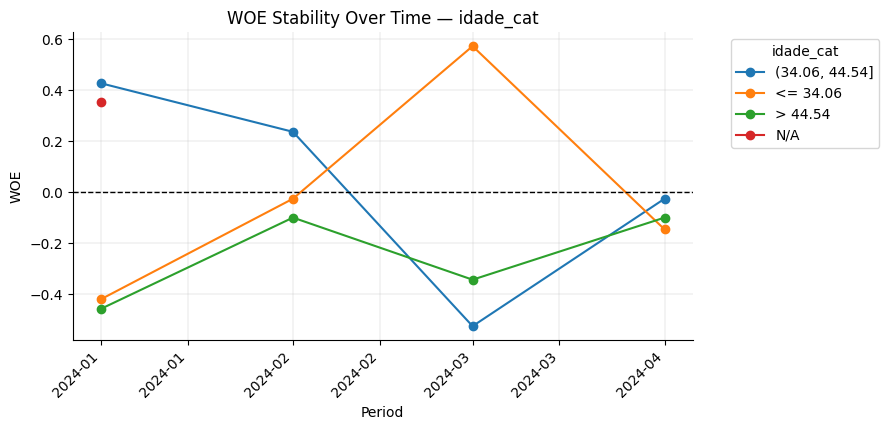

In [9]:
ws = WoeStability(df=df, date_col="period")

global_woe = ws.global_table(
    feature_col="renda_cat",
    target_col="vr",
)


# tabela global
global_woe = ws.global_table(
    feature_col="renda_cat",
    target_col="vr",
)
display(global_woe)
# gráfico em subplot existente
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ws.generate_view(
    feature_col="idade_cat",
    target_col="vr",
    ax=ax,
)

# Exemplo dados fraude

In [10]:

path = 'data/BAF_Base.csv'
df = pd.read_csv(path)
df_summary = get_summary(df=df)
df_summary

,column_name,dtype,n_na,pct_na,top_class,top_class_pct,n_distinct,distinct_values,min,max
0,fraud_bool,int64,0,0.0,0,98.8971,2,"[0, 1]",0.000000e+00,1.000000
1,income,float64,0,0.0,0.9,22.1419,9,"[0.3, 0.8, 0.6000000000000001, 0.9, 0.2, 0.1, ...",1.000000e-01,0.900000
2,name_email_similarity,float64,0,0.0,0.389347,0.0002,998861,...,1.434550e-06,0.999999
3,prev_address_months_count,int64,0,0.0,-1,71.2920,374,...,-1.000000e+00,383.000000
4,current_address_months_count,int64,0,0.0,6,1.6376,423,...,-1.000000e+00,428.000000
5,customer_age,int64,0,0.0,30,31.1433,9,"[40, 20, 30, 50, 60, 90, 80, 70, 10]",1.000000e+01,90.000000
6,days_since_request,float64,0,0.0,0.013961,0.0003,989330,...,4.036860e-09,78.456904
7,intended_balcon_amount,float64,0,0.0,-0.469019,0.0003,994971,...,-1.553055e+01,112.956928
8,payment_type,object,0,0.0,AB,37.0554,5,"[AA, AD, AB, AC, AE]",NaN,NaN
9,zip_count_4w,int64,0,0.0,1020,0.0798,6306,...,1.000000e+00,6700.000000


In [11]:
vr = 'fraud_bool'
var_cont = df_summary[df_summary['n_distinct'] > 10]['column_name'].tolist()
var_cat = df_summary[df_summary['n_distinct'] <= 10]['column_name'].tolist()
# remove target from var_cat if present
var_cat.remove(vr)
var_cat.remove('month')

In [12]:
df['flag_train'] = ~df['month'].isin([6, 7])

In [13]:
bins_dict = {}
binner = TreeBinner(
    max_depth=2,
    min_samples_leaf=1
)
applier = BinApplier(df)

for var in var_cont:
    binner.fit(df.query("flag_train==True"), feature=var, target=vr)
    bins = binner.bins_
    bins = [round(b, 2) for b in bins]
    bins = list(set(bins))
    # sort bins
    bins.sort()
    bins_dict[var] = bins
    
    df[f"{var}_cat"] = applier.apply(var, bins)

In [37]:
# converter as variaveis categorizadas para string, o missing foi tratado no apply binning
for var in var_cont:
    df[f"{var}_cat"] = df[f"{var}_cat"].astype("object").fillna("N/A")

for var in var_cat:
    df[f"{var}"] = df[f"{var}"].astype("object").fillna("N/A")


In [40]:
dict_to_join = {}
df_train = df.query("flag_train==True").copy()
get_summary(df=df_train)

,column_name,dtype,n_na,pct_na,top_class,top_class_pct,n_distinct,distinct_values,min,max
0,fraud_bool,int64,0,0.0,0,98.974703,2,"[0, 1]",0,1
1,income,object,0,0.0,0.9,20.403050,9,"[0.3, 0.8, 0.6000000000000001, 0.9, 0.2, 0.1, ...",None,None
2,name_email_similarity,float64,0,0.0,0.186042,0.000252,794245,...,0.000001,0.999999
3,prev_address_months_count,int64,0,0.0,-1,71.500738,370,...,-1,377
4,current_address_months_count,int64,0,0.0,7,1.581154,422,...,-1,425
5,customer_age,object,0,0.0,30,31.209363,9,"[40, 20, 30, 50, 60, 90, 80, 70, 10]",None,None
6,days_since_request,float64,0,0.0,0.02956,0.000377,788369,...,0.0,76.581477
7,intended_balcon_amount,float64,0,0.0,-0.50406,0.000377,791824,...,-15.530555,112.956928
8,payment_type,object,0,0.0,AB,36.249810,5,"[AA, AD, AB, AC, AE]",None,None
9,zip_count_4w,int64,0,0.0,1014,0.077108,6300,...,1,6700


,income,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,0.9,3305,158897,0.4055,0.2019,0.2040,0.6971,0.1419,0.239
1,0.8,1206,111085,0.1480,0.1412,0.1412,0.0469,0.0003,0.239
2,0.7000000000000001,707,82213,0.0867,0.1045,0.1043,-0.1862,0.0033,0.239
3,0.6000000000000001,746,89202,0.0915,0.1134,0.1131,-0.2141,0.0047,0.239
4,0.5,350,45254,0.0429,0.0575,0.0574,-0.2922,0.0043,0.239
5,0.4,461,66341,0.0566,0.0843,0.0840,-0.3993,0.0111,0.239
6,0.3,267,42038,0.0328,0.0534,0.0532,-0.4892,0.0101,0.239
7,0.2,361,57707,0.0443,0.0733,0.0730,-0.5044,0.0147,0.239
8,0.1,748,134101,0.0918,0.1704,0.1696,-0.6191,0.0487,0.239
9,__TOTAL__,8151,786838,1.0000,1.0000,1.0000,NaN,0.2390,0.239


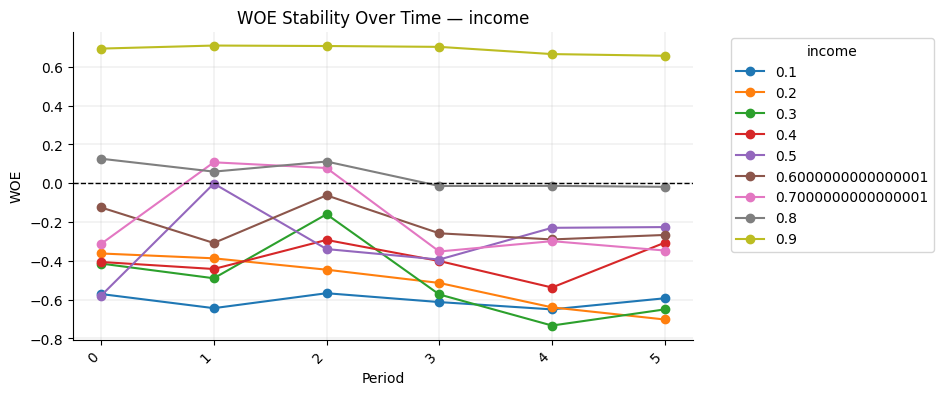

In [49]:
col_date = "month"
col_vr = 'fraud_bool'
col_var = var_cat[0]


ws = WoeStability(df=df_train, date_col=col_date)

# tabela global
global_woe = ws.global_table(
    feature_col=col_var,
    target_col=col_vr,
)
display(global_woe)
# gráfico em subplot existente
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ws.generate_view(
    feature_col=col_var,
    target_col=col_vr,
    ax=ax,
)

,income,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,0.9,3305,158897,0.4055,0.2019,0.2040,0.6971,0.1419,0.236
1,0.8,1206,111085,0.1480,0.1412,0.1412,0.0469,0.0003,0.236
2,0.7000000000000001 | 0.6000000000000001 | 0.5 ...,2264,283010,0.2778,0.3597,0.3588,-0.2585,0.0212,0.236
3,0.3 | 0.2 | 0.1,1376,233846,0.1688,0.2972,0.2959,-0.5656,0.0726,0.236
4,__TOTAL__,8151,786838,1.0000,1.0000,1.0000,NaN,0.2360,0.236


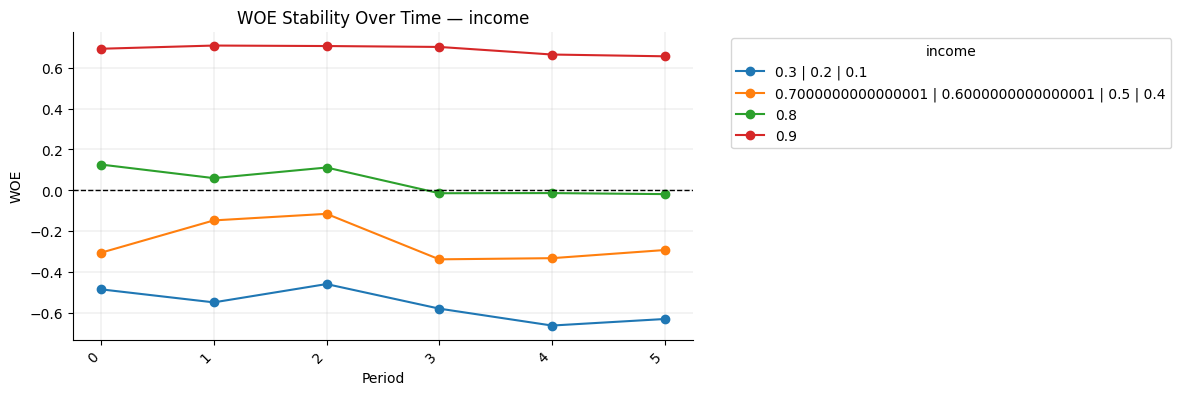

In [52]:
col_date = "month"
col_vr = 'fraud_bool'
col_var = var_cat[0]

mapper = CategoryMapper(
        global_table=global_woe,
        woe_col='woe',
        feature_name=col_var,
        category_col=col_var,
        total_label='__TOTAL__',
        separator=" | "
)
mapper.build_mapping(groups=[[2, 3, 4, 5], [6,7, 8]])

dict_to_replace = mapper.get_mapping(feature_name=col_var)



ws = WoeStability(df=df_train.replace({col_var: dict_to_replace}), date_col=col_date)

# tabela global
global_woe2 = ws.global_table(
    feature_col=col_var,
    target_col=col_vr,
)
display(global_woe2)
# gráfico em subplot existente
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ws.generate_view(
    feature_col=col_var,
    target_col=col_vr,
    ax=ax,
)

,customer_age,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,90,4,56,0.0005,0.0001,0.0001,1.9308,0.0008,0.3517
1,80,50,963,0.0061,0.0012,0.0013,1.6119,0.0079,0.3517
2,70,195,4983,0.0239,0.0063,0.0065,1.3291,0.0234,0.3517
3,60,872,27434,0.1070,0.0349,0.0356,1.1211,0.0809,0.3517
4,50,2175,112502,0.2668,0.1430,0.1442,0.6239,0.0773,0.3517
5,40,2032,180207,0.2493,0.2290,0.2292,0.0848,0.0017,0.3517
6,30,1875,246236,0.2300,0.3129,0.3121,-0.3078,0.0255,0.3517
7,20,896,198618,0.1099,0.2524,0.2510,-0.8313,0.1185,0.3517
8,10,52,15839,0.0064,0.0201,0.0200,-1.1491,0.0158,0.3517
9,__TOTAL__,8151,786838,1.0000,1.0000,1.0000,NaN,0.3517,0.3517


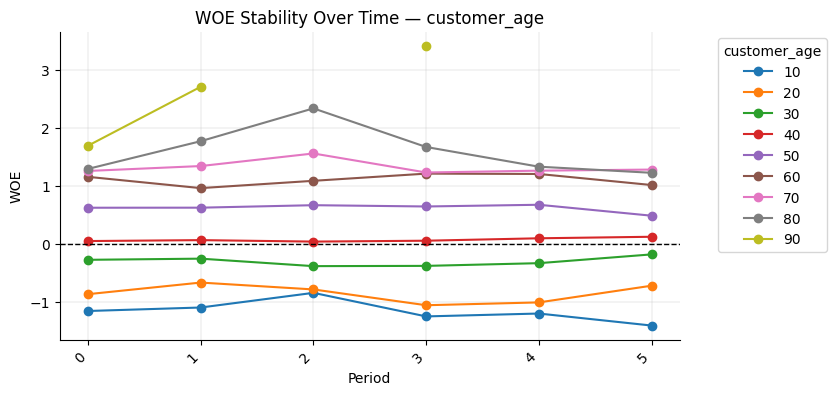

In [53]:
col_date = "month"
col_vr = 'fraud_bool'
col_var = var_cat[1]

ws = WoeStability(df=df_train, date_col=col_date)

# tabela global
global_woe = ws.global_table(
    feature_col=col_var,
    target_col=col_vr,
)
display(global_woe)
# gráfico em subplot existente
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ws.generate_view(
    feature_col=col_var,
    target_col=col_vr,
    ax=ax,
)

,customer_age,n_event,n_non_event,event_rate,non_event_rate,exposure,woe,iv,iv_total
0,90 | 80 | 70 | 60,1121,33436,0.1375,0.0425,0.0435,1.1745,0.1116,0.3492
1,50,2175,112502,0.2668,0.1430,0.1442,0.6239,0.0773,0.3492
2,40,2032,180207,0.2493,0.2290,0.2292,0.0848,0.0017,0.3492
3,30,1875,246236,0.2300,0.3129,0.3121,-0.3078,0.0255,0.3492
4,20 | 10,948,214457,0.1163,0.2726,0.2710,-0.8516,0.1331,0.3492
5,__TOTAL__,8151,786838,1.0000,1.0000,1.0000,NaN,0.3492,0.3492


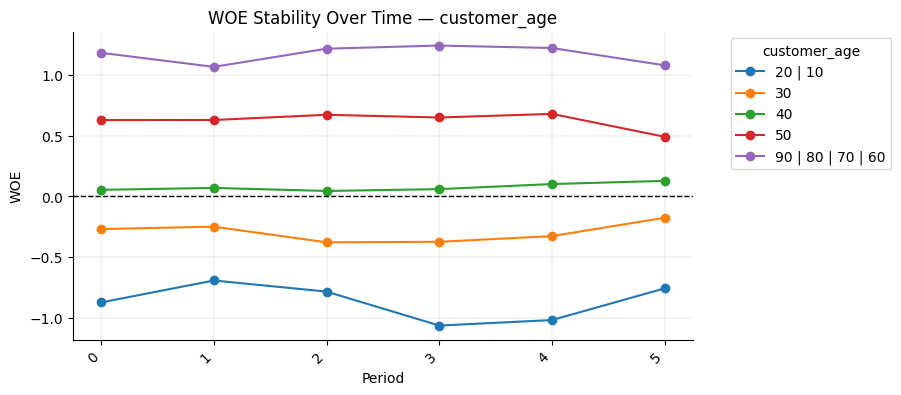

In [54]:
col_date = "month"
col_vr = 'fraud_bool'
col_var = var_cat[1]

mapper = CategoryMapper(
        global_table=global_woe,
        woe_col='woe',
        feature_name=col_var,
        category_col=col_var,
        total_label='__TOTAL__',
        separator=" | "
)
mapper.build_mapping(groups=[[0, 1, 2, 3], [7, 8]])

dict_to_replace = mapper.get_mapping(feature_name=col_var)



ws = WoeStability(df=df_train.replace({col_var: dict_to_replace}), date_col=col_date)

# tabela global
global_woe = ws.global_table(
    feature_col=col_var,
    target_col=col_vr,
)
display(global_woe)
# gráfico em subplot existente
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ws.generate_view(
    feature_col=col_var,
    target_col=col_vr,
    ax=ax,
)

In [34]:
df_train.replace({col_var: dict_to_replace})[col_var].unique()

array([40, 20, 30, 50, 60, 90, 80, 70, 10])